In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pymc3.gp.util import plot_gp_dist
#import matplotlib.cm as cmap

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm

import pickle

import time

pm.__version__

from scipy import stats
from scipy.special import expit as logistic

import arviz as az

import math

import pygame

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


### Loading pickles regarding data and map estimates for hyperparemeters from non-spars estimation

In [2]:
# Tror mpske kun jeg skal bruge point...

pkl_file = open('full_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

In [3]:
pkl_file = open('map.pkl', 'rb')

mp = pickle.load(pkl_file)

pkl_file.close()

In [4]:
# MAP estimates from non-spars estimation
mp

{'η': array([0.74898533]),
 'η_log__': array([-0.28903589]),
 'σ': array([0.72533913]),
 'σ_log__': array([-0.32111597]),
 'ℓ': array([1.16623133]),
 'ℓ_log__': array([0.15377746])}

In [5]:
# The data

year = 2017

y_north_limit = 50
y_south_limit = - 10
x_east_limit = 100
x_west_limit  = -20

df_sub = df[(df['year']==year)&(df['ycoord'] > y_south_limit)&(df['ycoord'] < y_north_limit)&(df['xcoord']<x_east_limit)&(df['xcoord']>x_west_limit)]


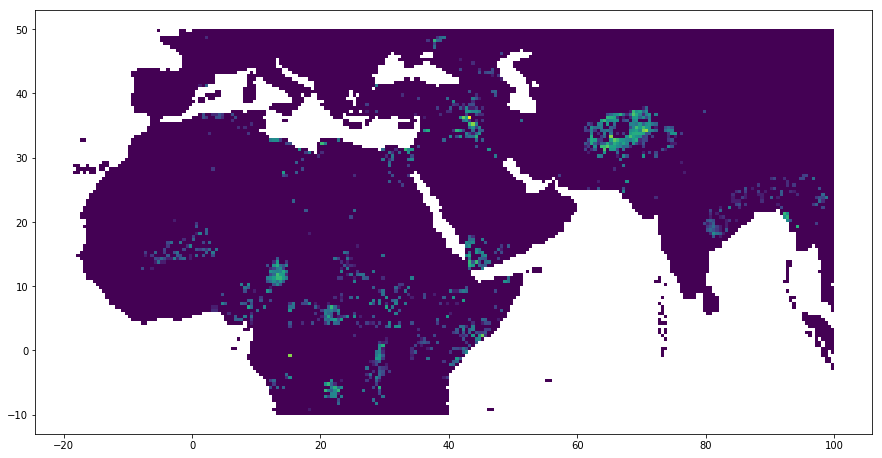

In [6]:
df_sub.plot(column = 'log_best', figsize=(15, 15))
plt.show()

## Estimation
In function:

In [7]:
def get_year_data(year=year):
    df_sub = df[(df['year']==year)&(df['ycoord'] > y_south_limit)&(df['ycoord'] < y_north_limit)&(df['xcoord']<x_east_limit)&(df['xcoord']>x_west_limit)]

    X = np.array([df_sub['xcoord'], df_sub['ycoord']]).T
    y = np.array(df_sub['log_best'])
    
    # for spares
    sub1 = df_sub[df_sub['best']>0]
    Xu = np.array([sub1['xcoord'], sub1['ycoord']]).T

    return(X, y, Xu)

In [8]:
def model_est(y, X, Xu):    
    # The Model
    with pm.Model() as model:

        # lenght-scale and amplitude hyperparameter for the spatial dispertion
        ℓ = pm.Gamma("ℓ", alpha=2, beta=2, shape = 1)
        η = pm.HalfCauchy("η", beta=5, shape = 1)

        # noise
        σ = pm.HalfCauchy("σ", beta=2, shape = 1)
        
        # Covariance. Assume long. and lat share on cov_func.
        cov = η **2 * pm.gp.cov.ExpQuad(2, ℓ)
        
        # The GP
        gp = pm.gp.MarginalSparse(cov_func=cov, approx="DTC") # ved ikke om det gør en forskel til FICT
        y_ = gp.marginal_likelihood("y_", X=X, Xu = Xu, y=y, noise= σ)
        
    mu, var = gp.predict(X, point=mp, given = {'gp' : gp, 'X' : X, 'y' : y, 'noise' : σ }, diag=True)
        
    return(mu, var)

In [9]:
def model_run(year):
    # timer
    time0 = time.time()
    
    # get the year specific data:
    X, y, Xu = get_year_data(year = year)
    
    # model funcs
    mu, var = model_est(y=y, X = X, Xu = Xu)
    
    # Time stamp:
    time2 = time.time()
    timet = (time2 - time0)/60
    print('toltal: {} min'.format(timet))
   

    file_name = "spatial_est_{}.pkl".format(year)
    output = open(file_name, 'wb') # still not working right!!
    
    estimates = {'mu':mu,'var':var}
    
    pickle.dump(estimates, output)
    output.close()

    # output:
#     return(mu,var)

In [10]:
def model_loop(start, end):    
    year_list = np.sort(df['year'].unique())

    for i in year_list[start:end]:
        year = i
        model_run(year)
        print('{} done\n'.format(i))

    print('DONE!')

# IMPORTANT

So for some reason my memory gets clogged and I have tried every thing to ammend this in the loop with no real succes. Running alle cells below will take up more then 32 GB ram (mayby even more then 64..). Thus I am now simply runnig the notebook 7 times. Each time only running **ONE of the following cells!**. Afterwards I restart the ptyhon kernel, run the cells above again and then **ONE** new cell below. Iterate ontil all years are estimated.

In [11]:
def done_tune():
    # Play a tune when done.
    path ='/home/polichinel/Downloads/mp3/FFVII Victory Fanfare Ringtone(Dracotonis).mp3'

    pygame.mixer.init()
    pygame.mixer.music.load(path)
    pygame.mixer.music.play()

In [18]:
model_loop(0,5)
done_tune()

toltal: 0.8140219926834107 min
1989 done

toltal: 0.9179403384526571 min
1990 done

toltal: 0.8705343166987102 min
1991 done

toltal: 1.3296098709106445 min
1992 done

toltal: 1.3074807286262513 min
1993 done

DONE!


In [12]:
model_loop(5,10)
done_tune()

toltal: 1.5693638602892557 min
1994 done

toltal: 1.3308784723281861 min
1995 done

toltal: 1.21491752465566 min
1996 done

toltal: 1.2364629745483398 min
1997 done

toltal: 1.745367952187856 min
1998 done

DONE!


In [12]:
model_loop(10,15)
done_tune()

toltal: 1.907322931289673 min
1999 done

toltal: 1.8241509397824605 min
2000 done

toltal: 1.6012797315915426 min
2001 done

toltal: 1.7482134183247884 min
2002 done

toltal: 1.6083596428235372 min
2003 done

DONE!


In [12]:
model_loop(15,20)
done_tune()

toltal: 1.9552616119384765 min
2004 done

toltal: 1.746069041887919 min
2005 done

toltal: 2.2367664059003194 min
2006 done

toltal: 2.3650690356890363 min
2007 done

toltal: 2.535334050655365 min
2008 done

DONE!


In [12]:
model_loop(20,25)
done_tune()

toltal: 2.688096849123637 min
2009 done

toltal: 2.332313911120097 min
2010 done

toltal: 2.8524152716000875 min
2011 done

toltal: 3.03471356232961 min
2012 done

toltal: 2.9351805090904235 min
2013 done

DONE!


In [12]:
model_loop(25,29)
done_tune()

toltal: 3.2843698263168335 min
2014 done

toltal: 3.6920012553532917 min
2015 done

toltal: 3.295747415224711 min
2016 done

toltal: 3.6673725207646686 min
2017 done

DONE!


# load a test pickle and show:

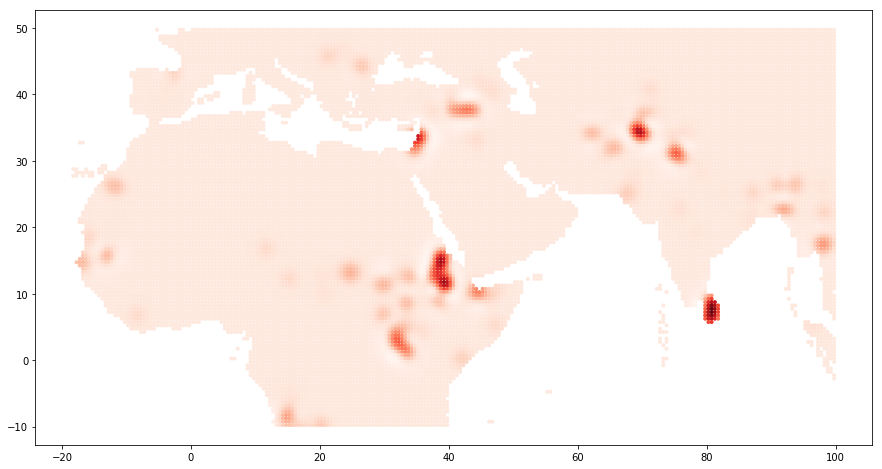

In [21]:
pkl_file = open('spatial_est_1989.pkl', 'rb')

estimates = pickle.load(pkl_file)

pkl_file.close()

X = np.array([df_sub['xcoord'], df_sub['ycoord']]).T

plt.figure(figsize=[15,8])
plt.scatter(X[:,0], X[:,1], s=35, c=estimates['mu'], marker='.', cmap='Reds')
plt.show()

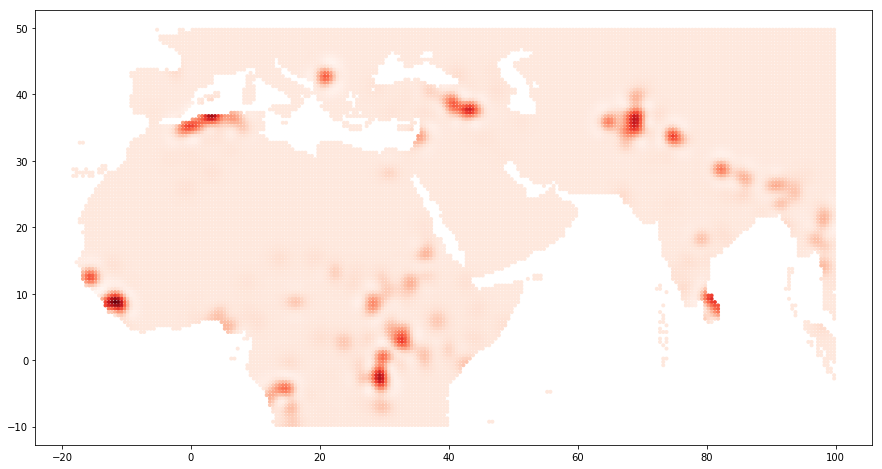

In [13]:
pkl_file = open('spatial_est_1998.pkl', 'rb')

estimates = pickle.load(pkl_file)

pkl_file.close()

X = np.array([df_sub['xcoord'], df_sub['ycoord']]).T

plt.figure(figsize=[15,8])
plt.scatter(X[:,0], X[:,1], s=35, c=estimates['mu'], marker='.', cmap='Reds')
plt.show()

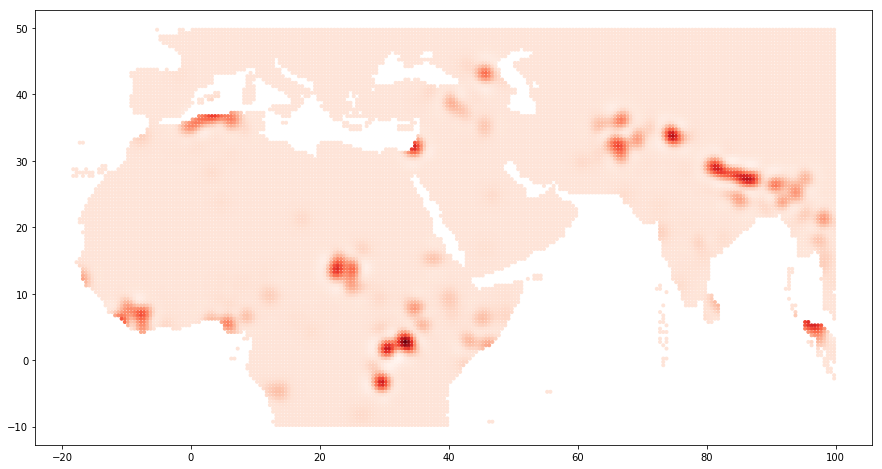

In [13]:
pkl_file = open('spatial_est_2003.pkl', 'rb')

estimates = pickle.load(pkl_file)

pkl_file.close()

X = np.array([df_sub['xcoord'], df_sub['ycoord']]).T

plt.figure(figsize=[15,8])
plt.scatter(X[:,0], X[:,1], s=35, c=estimates['mu'], marker='.', cmap='Reds')
plt.show()

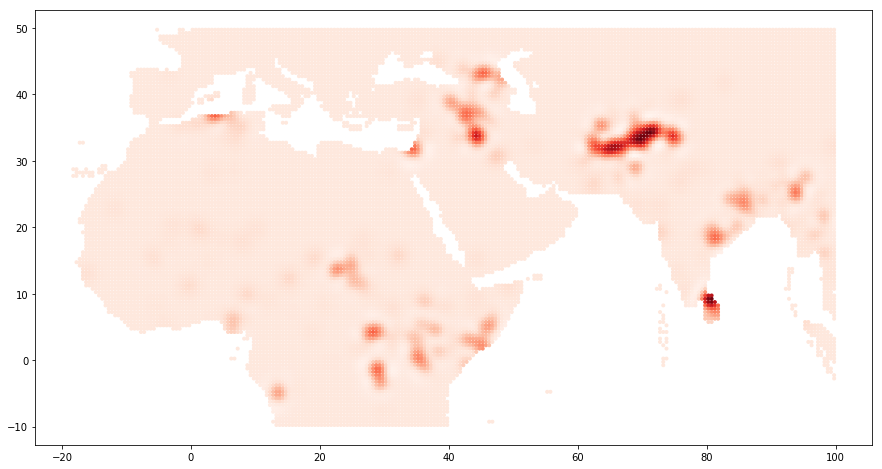

In [13]:
pkl_file = open('spatial_est_2008.pkl', 'rb')

estimates = pickle.load(pkl_file)

pkl_file.close()

X = np.array([df_sub['xcoord'], df_sub['ycoord']]).T

plt.figure(figsize=[15,8])
plt.scatter(X[:,0], X[:,1], s=35, c=estimates['mu'], marker='.', cmap='Reds')
plt.show()

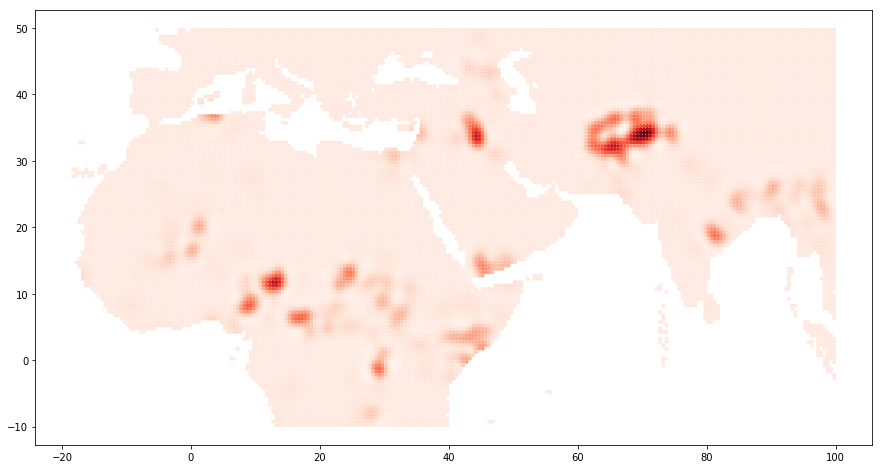

In [13]:
pkl_file = open('spatial_est_2013.pkl', 'rb')

estimates = pickle.load(pkl_file)

pkl_file.close()

X = np.array([df_sub['xcoord'], df_sub['ycoord']]).T

plt.figure(figsize=[15,8])
plt.scatter(X[:,0], X[:,1], s=35, c=estimates['mu'], marker='.', cmap='Reds')
plt.show()

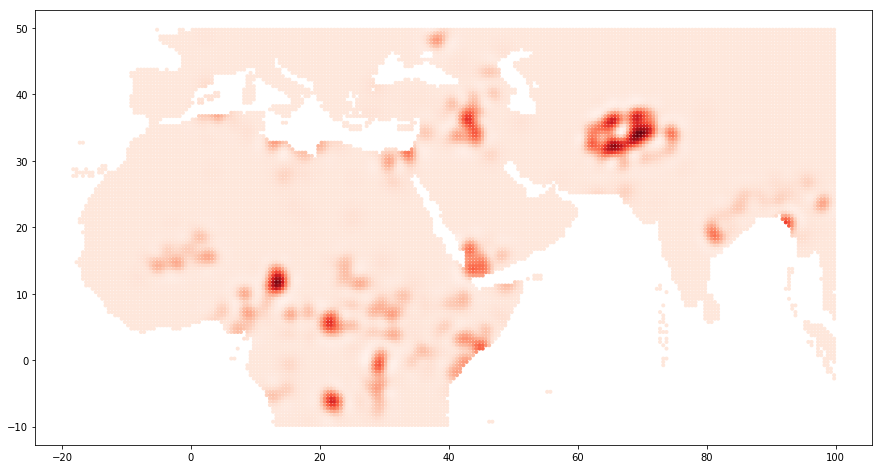

In [13]:
pkl_file = open('spatial_est_2017.pkl', 'rb')

estimates = pickle.load(pkl_file)

pkl_file.close()

X = np.array([df_sub['xcoord'], df_sub['ycoord']]).T

plt.figure(figsize=[15,8])
plt.scatter(X[:,0], X[:,1], s=35, c=estimates['mu'], marker='.', cmap='Reds')
plt.show()